# **Deliverable-I**
**Data Preprocessing**

**Loading the Dataset**

In [39]:
import re
import pandas as pd
import numpy as np

data = pd.read_csv('C:/Users/welcome/Downloads/Products_Data.csv')
data_copy = data.copy(deep=True)
data.head()


,Brand,Model,Price,Number of Ratings,Display Size,RAM,Battery,Internal Memory
0,Infinix,Zero 40 4G,"Rs.70,000",23,6.78 inches,8GB,500mAh,256GB
1,Samsung,Galaxy Z Flip 6,"Rs.385,000",39,6.7 inches,12GB,4000mAh,512GB
2,Samsung,Galaxy Z Fold 6,"Rs.605,000",45,7.6 inches,12GB,4400mAh,512GB
3,Samsung,Galaxy A05,"Rs.25,000",56,6.7 inches,4GB,5000mAh,64GB
4,Tecno,Phantom V Fold 2 5G,"Rs.370,000",37,7.85 inches,12GB,5750mAh,512GB


**Standardizing columns : RAM, Display Size, Battery, Internal Memory**

In [43]:
#defining patterns for identifying values
standard_ram_pattern = re.compile(r'^\d+\s*GB$', re.IGNORECASE) #this regex deals with values ending with a single RAM value having unit=GB
extended_ram_pattern = re.compile(r'(\d+)\s*GB', re.IGNORECASE) #this regex deals with values having multiple RAM

import re
import numpy as np

def standardize_RAM(ram_value):
    ram_value = ram_value.strip() #removing white spaces
    gb_matches = []
    if 'MB' in ram_value.upper(): #handling RAM having unit of MB
        mb_match = re.search(r'(\d+)\s*MB', ram_value, re.IGNORECASE)
        if mb_match:
            mb_value = int(mb_match.group(1))
            return f'{mb_value / 1024:.3f}'  # Converting MB to GB


    if '/' in ram_value or ',' in ram_value: #handling cases where multiple RAM values are separated by a "," or "/"
        all_numeric_values = re.findall(r'(\d+)', ram_value) #regex finding all integers in the string
        if all_numeric_values:
            ram_values = [int(value) for value in all_numeric_values] #converting into integer
            return str(min(ram_values))  # Return the minimum value among all


    if 'EXTENDED' in ram_value.upper(): #handling cases where RAM has extension
      # Extracting RAM values in GB
      gb_matches = re.findall(r'(\d+)\s*GB', ram_value, re.IGNORECASE)
      if gb_matches:
            return str(gb_matches[0])  # Returning the static value (which is the first GB value)

    if 'DYNAMIC' in ram_value.upper(): #handling cases where RAM is dynamic
        gb_matches = re.findall(r'(\d+)\s*GB', ram_value, re.IGNORECASE)
        if gb_matches:
            ram_values = [int(gb) for gb in gb_matches]
            return str(min(ram_values))  # Return the minimum value that is the static RAM
    gb_matches = re.findall(r'(\d+)\s*GB', ram_value, re.IGNORECASE)
    if gb_matches: #simple case
        return str(gb_matches[0])

    return np.nan



def extract_battery_value(battery):
    battery = battery.strip()

    # Handling standard mAh values
    if re.match(r'^\d+mAh$', battery): #regex matching values ending with mAh
        return int(re.findall(r'\d+', battery)[0]) #returning the integer part of battery

    # Handling 'mAhBattery' or 'mAh Battery' cases
    if re.match(r'^\d+\s*mAhBattery$', battery):
        return int(re.findall(r'\d+', battery)[0]) #returning the integer part of battery

    # Handling missing numerical values where only WhBattery or mAHBattery is written
    if battery == 'WhBattery' or battery == 'mAhBattery':
        return np.nan

    # Handling cases where battery unit is in Wh Assuming 1Wh = 1mAh
    if re.match(r'^\d+\s*WhBattery$', battery): #matching strings ending with WhBattery
        wh_value = int(re.findall(r'\d+', battery)[0])
        mah_value = wh_value
        return mah_value

    return np.nan


def standardize_internal_memory(memory_value):
    memory_value = memory_value.strip()
    if 'MB' or 'Mb' in memory_value:
        mb_match = re.search(r'(\d+)\s*(MB|Mb)', memory_value, re.IGNORECASE)
        if mb_match:
            mb_value = int(mb_match.group(1))
            return f'{mb_value / 1024:.3f}'  # Converting MB to GB

    if 'TB' or 'Tb' in memory_value:
        tb_match = re.search(r'(\d+)\s*(TB|Tb)$', memory_value, re.IGNORECASE)
        if tb_match:
            tb_value = int(tb_match.group(1))
            return f'{tb_value * 1024:.3f}'  # Convert TB to GB

    # Handling standard format
    if re.match(r'^\d+\s*GB$', memory_value, re.IGNORECASE):
        return int(re.search(r'\d+', memory_value).group())  # returning only numeric part

    # Handling multiple values (separated by spaces, '/', or ',')
    if ' ' in memory_value or '/' in memory_value or ',' in memory_value:
        all_numeric_values = re.findall(r'(\d+)', memory_value)
        if all_numeric_values:
            memory_values = [int(value) for value in all_numeric_values]
            return str(min(memory_values))  # Returning the minimum value

    if 'EXTENDED' in memory_value.upper():
        first_match = re.search(r'\d+', memory_value)
        if first_match:
            return int(first_match.group()) #for multiple RAM values where the RAM is extended, the static part is selected only

    if 'expandable' in memory_value or '(' in memory_value:
        first_match = re.search(r'\d+', memory_value)
        if first_match:
            return int(first_match.group())  #for multiple RAM values where the RAM is expandable, the static part is selected only

    return np.nan  # Return NaN if no match is found


def extract_display_size(display):
    display = display.strip()

    # Extract the numeric value from the string
    display_size_match = re.search(r'(\d+(\.\d+)?)', display)
    if display_size_match:
        return float(display_size_match.group())  # Converting to float

    # Return NaN for non-matching cases
    return np.nan


def Standardize_price(price):
    price = price.strip()
    # Extract numeric value, allowing for commas
    price_match = re.search(r'(\d{1,3}(,\d{3})*(\.\d+)?)', price)
    if price_match:
        # Remove commas and convert to float
        return float(price_match.group().replace(',', ''))
    return np.nan


def Standardize_rating(rating):
    rating = rating.strip()
    rating_match = re.search(r'(\d+(\.\d+)?)', rating)
    if rating_match:
        return float(rating_match.group())
    # Return NaN if no numeric value is found
    return np.nan


**Displaying Standardized Columns**

In [44]:
data['Price'] = data['Price'].apply(Standardize_price)
data['Number of Ratings'] = data['Number of Ratings'].apply(Standardize_rating)
data['RAM'] = data['RAM'].apply(standardize_RAM)
data['Battery'] = data['Battery'].apply(extract_battery_value)
data['Internal Memory'] = data['Internal Memory'].apply(standardize_internal_memory)
data['Display Size'] = data['Display Size'].apply(extract_display_size)


# Print the old and new columns side by side
print(data[['Price', 'Number of Ratings' ,'RAM',  'Battery', 'Internal Memory',  'Display Size', ]].to_string(index=False))


   Price  Number of Ratings   RAM  Battery Internal Memory  Display Size
 70000.0               23.0     8    500.0             256         6.780
385000.0               39.0    12   4000.0             512         6.700
605000.0               45.0    12   4400.0             512         7.600
 25000.0               56.0     4   5000.0              64         6.700
370000.0               37.0    12   5750.0             512         7.850
200000.0               20.0     8   4720.0             256         6.900
 30000.0               22.0     8   5050.0             256         6.500
229999.0               47.0    12   5000.0             512         6.670
385000.0               45.0    12   4000.0             512         6.700
605000.0               20.0    12   4400.0             512         7.600
130000.0               16.0    12   5000.0             256         6.700
175999.0               42.0    12   5000.0             512         6.670
147000.0               41.0    12   5000.0         

**Data Exploration**

In [45]:
data.head()

,Brand,Model,Price,Number of Ratings,Display Size,RAM,Battery,Internal Memory
0,Infinix,Zero 40 4G,70000.0,23.0,6.78,8,500.0,256
1,Samsung,Galaxy Z Flip 6,385000.0,39.0,6.70,12,4000.0,512
2,Samsung,Galaxy Z Fold 6,605000.0,45.0,7.60,12,4400.0,512
3,Samsung,Galaxy A05,25000.0,56.0,6.70,4,5000.0,64
4,Tecno,Phantom V Fold 2 5G,370000.0,37.0,7.85,12,5750.0,512


In [46]:
data.tail()

,Brand,Model,Price,Number of Ratings,Display Size,RAM,Battery,Internal Memory
1340,gfive,GFive Disco,3199.0,59.0,2.40,0.031,3000.0,0.031
1341,gfive,GFive Spark,2325.0,3.0,1.80,0.031,3000.0,0.031
1342,e-tachi,E-Tachi E888,3749.0,38.0,2.80,0.031,3000.0,0.031
1343,sparx,SparX Edge 20,5000.0,24.0,6.67,8,5000.0,256
1344,gfive,GFive 4G Style,6999.0,39.0,2.80,2,4000.0,16


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              1345 non-null   object 
 1   Model              1345 non-null   object 
 2   Price              1329 non-null   float64
 3   Number of Ratings  1345 non-null   float64
 4   Display Size       1345 non-null   float64
 5   RAM                1339 non-null   object 
 6   Battery            1342 non-null   float64
 7   Internal Memory    1344 non-null   object 
dtypes: float64(4), object(4)
memory usage: 84.2+ KB


In [48]:
data.describe()

,Price,Number of Ratings,Display Size,Battery
count,1329.000000,1345.000000,1345.000000,1342.000000
mean,94698.823928,35.976208,6.249314,5044.555887
std,134644.912823,65.542239,1.179237,13556.005191
min,2250.000000,2.000000,0.000000,30.000000
25%,23000.000000,6.000000,6.500000,5000.000000
50%,40000.000000,20.000000,6.600000,5000.000000
75%,90000.000000,43.000000,6.700000,5000.000000
max,735000.000000,991.000000,7.850000,500018.000000


**Data Cleaning**

In [49]:
data.isnull().sum()

Brand                 0
Model                 0
Price                16
Number of Ratings     0
Display Size          0
RAM                   6
Battery               3
Internal Memory       1
dtype: int64

In [50]:
#changing datatypes
data['RAM'] = pd.to_numeric(data['RAM'], errors='coerce')
data['Battery'] = pd.to_numeric(data['Battery'], errors='coerce')
data['Internal Memory'] = pd.to_numeric(data['Internal Memory'], errors='coerce')
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
data['Number of Ratings'] = pd.to_numeric(data['Number of Ratings'], errors='coerce')
data.dtypes

Brand                 object
Model                 object
Price                float64
Number of Ratings    float64
Display Size         float64
RAM                  float64
Battery              float64
Internal Memory      float64
dtype: object

In [51]:
#FILLING MISSING VALUES OF RAM
#data['RAM'] = data.groupby('Model')['RAM'].transform(lambda x: x.ffill())
#data["RAM"].isnull().sum()
global_mean = data['RAM'].mean()
data['RAM'] = data['RAM'].fillna(global_mean)
data['RAM'].isnull().sum()

0

In [54]:
#FILLING MISSING VALUES OF INTERNAL MEMORY
global_mean = data['Internal Memory'].mean()
data['Internal Memory'] = data['Internal Memory'].fillna(global_mean)
data['Internal Memory'].isnull().sum()


0

In [53]:
#FILLING MISSING VALUES OF DISPLAY SIZE
def impute_display_size(val):
    mean = val.mean()
    if not np.isnan(mean):
        return mean
    else:
        return np.nan
#applying forward fill by grouping brand and model because devices of same brand and model are highly likely to have same Display Size
data['Display Size'] = data.groupby(['Brand', 'Model'])['Display Size'].transform(lambda x: x.fillna(impute_display_size(x)))
data["Display Size"].isnull().sum()


0

In [55]:
#FILLING MISSING VALUES OF PRICE
global_mean = data['Price'].mean()
data['Price'] = data['Price'].fillna(global_mean)
data['Price'].isnull().sum()

0

In [56]:
#FILLING MISSING VALUES OF BATTERY
global_mean = data['Battery'].mean()
data['Battery'] = data['Battery'].fillna(global_mean)
data['Battery'].isnull().sum()

0

In [57]:
#removing Duplicate values
data.drop_duplicates(inplace=True)
data

,Brand,Model,Price,Number of Ratings,Display Size,RAM,Battery,Internal Memory
0,Infinix,Zero 40 4G,70000.0,23.0,6.78,8.000,500.0,256.000
1,Samsung,Galaxy Z Flip 6,385000.0,39.0,6.70,12.000,4000.0,512.000
2,Samsung,Galaxy Z Fold 6,605000.0,45.0,7.60,12.000,4400.0,512.000
3,Samsung,Galaxy A05,25000.0,56.0,6.70,4.000,5000.0,64.000
4,Tecno,Phantom V Fold 2 5G,370000.0,37.0,7.85,12.000,5750.0,512.000
...,...,...,...,...,...,...,...,...
1340,gfive,GFive Disco,3199.0,59.0,2.40,0.031,3000.0,0.031
1341,gfive,GFive Spark,2325.0,3.0,1.80,0.031,3000.0,0.031
1342,e-tachi,E-Tachi E888,3749.0,38.0,2.80,0.031,3000.0,0.031
1343,sparx,SparX Edge 20,5000.0,24.0,6.67,8.000,5000.0,256.000


In [58]:

# Identifying the outliers of RAM
print("mean",data['RAM'].mean())
print("mode",data['RAM'].mode())
print("median",data['RAM'].median())
print("the mean, median and mode are not equal or close so, the data is not normally distributed")

Q1 = data['RAM'].quantile(0.25)
Q3 = data['RAM'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['RAM'] < lower_bound) | (data['RAM'] > upper_bound)]
ram_outliers = outliers['RAM']
print("Outliers detected for RAM:")
print(ram_outliers)
print("number of outliers: ", outliers.shape[0])

mean 6.861750941366325
mode 0    8.0
Name: RAM, dtype: float64
median 6.0
the mean, median and mode are not equal or close so, the data is not normally distributed
Outliers detected for RAM:
115      16.0
1008     24.0
1011    256.0
1032     64.0
1048     16.0
1058    128.0
1088     16.0
1107     16.0
1127    512.0
1134     20.0
1142    128.0
1157     16.0
1213     16.0
1226     16.0
1264     16.0
Name: RAM, dtype: float64
number of outliers:  15


In [59]:
#Identifying Outliers of internal memory
print("mean",data['Internal Memory'].mean())
print("mode",data['Internal Memory'].mode())
print("median",data['Internal Memory'].median())
print("the mean, median and mode are not equal or close so, the data is not normally distributed")

Q1 = data['Internal Memory'].quantile(0.25)
Q3 = data['Internal Memory'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Internal Memory'] < lower_bound) | (data['Internal Memory'] > upper_bound)]

Internal_Memory_outliers = outliers['Internal Memory']
print("Outliers detected for Internal Memory:")
print(Internal_Memory_outliers)
print("number of outliers: ", outliers.shape[0])

mean 166.64049048174047
mode 0    128.0
Name: Internal Memory, dtype: float64
median 128.0
the mean, median and mode are not equal or close so, the data is not normally distributed
Outliers detected for Internal Memory:
1072    1024.0
1154    1024.0
1273    1024.0
1324    1024.0
Name: Internal Memory, dtype: float64
number of outliers:  4


In [60]:
#Identifying Outliers of display size
print("mean",data['Display Size'].mean())
print("mode",data['Display Size'].mode())
print("median",data['Display Size'].median())
print("the mean, median and mode are not equal or close so, the data is not normally distributed (left-skewed)")

Q1 = data['Display Size'].quantile(0.25)
Q3 = data['Display Size'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Display Size'] < lower_bound) | (data['Display Size'] > upper_bound)]

Display_Size_outliers = outliers['Display Size']
print("Outliers detected for Display Size:")
print(Display_Size_outliers)
print("number of outliers: ", outliers.shape[0])

mean 6.239120435120435
mode 0    6.6
Name: Display Size, dtype: float64
median 6.6
the mean, median and mode are not equal or close so, the data is not normally distributed (left-skewed)
Outliers detected for Display Size:
2       7.60
4       7.85
9       7.60
14      7.85
63      2.80
        ... 
1336    2.40
1340    2.40
1341    1.80
1342    2.80
1344    2.80
Name: Display Size, Length: 199, dtype: float64
number of outliers:  199


In [61]:
#Identifying Outliers of Battery
print("mean",data['Battery'].mean())
print("mode",data['Battery'].mode())
print("median",data['Battery'].median())
print("the mean, median and mode are not equal or close so, the data is not normally distributed (right-skewed)")

Q1 = data['Battery'].quantile(0.25)
Q3 = data['Battery'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Battery'] < lower_bound) | (data['Battery'] > upper_bound)]

Battery_outliers = outliers['Battery']
print("Outliers detected for Battery:")
print(Battery_outliers)
print("number of outliers: ", outliers.shape[0])

mean 5054.078995850978
mode 0    5000.0
Name: Battery, dtype: float64
median 5000.0
the mean, median and mode are not equal or close so, the data is not normally distributed (right-skewed)
Outliers detected for Battery:
0        500.0
1       4000.0
2       4400.0
4       5750.0
5       4720.0
         ...  
1336    2500.0
1340    3000.0
1341    3000.0
1342    3000.0
1344    4000.0
Name: Battery, Length: 394, dtype: float64
number of outliers:  394


In [62]:
#Identifying Outliers of Price
print("mean",data['Price'].mean())
print("mode",data['Price'].mode())
print("median",data['Price'].median())
print("the mean, median and mode are not equal or close so, the data is not normally distributed")

Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Price'] < lower_bound) | (data['Price'] > upper_bound)]
Price_outliers = outliers['Price']
print("Outliers detected for Price:")
print(Price_outliers)
print("number of outliers: ", outliers.shape[0])

mean 95502.0079120779
mode 0    25000.0
Name: Price, dtype: float64
median 40000.0
the mean, median and mode are not equal or close so, the data is not normally distributed
Outliers detected for Price:
1       385000.0
2       605000.0
4       370000.0
7       229999.0
8       385000.0
          ...   
1274    278999.0
1279    309999.0
1280    369999.0
1290    245999.0
1324    444999.0
Name: Price, Length: 164, dtype: float64
number of outliers:  164


In [63]:
#Identifying Outliers of Ratings
print("mean",data['Number of Ratings'].mean())
print("mode",data['Number of Ratings'].mode())
print("median",data['Number of Ratings'].median())
print("the mean, median and mode are not equal or close so, the data is not normally distributed")

Q1 = data['Number of Ratings'].quantile(0.25)
Q3 = data['Number of Ratings'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Number of Ratings'] < lower_bound) | (data['Number of Ratings'] > upper_bound)]

Ratings_outliers = outliers['Number of Ratings']
print("Outliers detected for Number of Ratings:")
print(Ratings_outliers)
print("number of outliers: ", outliers.shape[0])

mean 36.084693084693086
mode 0    3.0
Name: Number of Ratings, dtype: float64
median 20.0
the mean, median and mode are not equal or close so, the data is not normally distributed
Outliers detected for Number of Ratings:
63      123.0
67      127.0
69      127.0
77      148.0
92      131.0
        ...  
1315    346.0
1325    190.0
1327    129.0
1337    351.0
1339    207.0
Name: Number of Ratings, Length: 87, dtype: float64
number of outliers:  87


***no need to remove the outliers, as there are different types of phones from various brands, which may have very different features from each other, causing the outliers***




**Data Transformation**

In [64]:
#encoding Model column data through one-hot encoding since there is no order in the column
one_hot_encoded_data = pd.get_dummies(data['Model'], prefix='Model', drop_first=True)
data = pd.concat([data, one_hot_encoded_data], axis=1)

data.head()

,Brand,Model,Price,Number of Ratings,Display Size,RAM,Battery,Internal Memory,Model_12 4G,Model_12+ 5G,...,Model_itel P55 Plus,Model_itel S23 Plus,Model_itel Value 110s,Model_me Mobile M-1110,Model_nubia Focus 5G,Model_nubia Focus Pro 5G,Model_nubia Music,Model_nubia Neo 2,Model_nubia V60 Design,Model_smart Nova 5
0,Infinix,Zero 40 4G,70000.0,23.0,6.78,8.0,500.0,256.0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Samsung,Galaxy Z Flip 6,385000.0,39.0,6.70,12.0,4000.0,512.0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Samsung,Galaxy Z Fold 6,605000.0,45.0,7.60,12.0,4400.0,512.0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Samsung,Galaxy A05,25000.0,56.0,6.70,4.0,5000.0,64.0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Tecno,Phantom V Fold 2 5G,370000.0,37.0,7.85,12.0,5750.0,512.0,False,False,...,False,False,False,False,False,False,False,False,False,False


In [65]:
#encoding Brand column data through label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Brand_Encoded'] = label_encoder.fit_transform(data['Brand'])
data.head()

,Brand,Model,Price,Number of Ratings,Display Size,RAM,Battery,Internal Memory,Model_12 4G,Model_12+ 5G,...,Model_itel S23 Plus,Model_itel Value 110s,Model_me Mobile M-1110,Model_nubia Focus 5G,Model_nubia Focus Pro 5G,Model_nubia Music,Model_nubia Neo 2,Model_nubia V60 Design,Model_smart Nova 5,Brand_Encoded
0,Infinix,Zero 40 4G,70000.0,23.0,6.78,8.0,500.0,256.0,False,False,...,False,False,False,False,False,False,False,False,False,8
1,Samsung,Galaxy Z Flip 6,385000.0,39.0,6.70,12.0,4000.0,512.0,False,False,...,False,False,False,False,False,False,False,False,False,17
2,Samsung,Galaxy Z Fold 6,605000.0,45.0,7.60,12.0,4400.0,512.0,False,False,...,False,False,False,False,False,False,False,False,False,17
3,Samsung,Galaxy A05,25000.0,56.0,6.70,4.0,5000.0,64.0,False,False,...,False,False,False,False,False,False,False,False,False,17
4,Tecno,Phantom V Fold 2 5G,370000.0,37.0,7.85,12.0,5750.0,512.0,False,False,...,False,False,False,False,False,False,False,False,False,19


In [66]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical_cols = ['RAM', 'Internal Memory', 'Price', 'Number of Ratings', 'Display Size']

scaled_data = scaler.fit_transform(data[numerical_cols])

scaled_df = pd.DataFrame(
    scaled_data, 
    columns=['RAM_Scaled', 'Internal_Memory_Scaled', 'Price_Scaled', 'Number_of_Ratings_Scaled', 'Display_Size_Scaled'],
    index=data.index
)

data = pd.concat([data, scaled_df], axis=1)

data.head()


,Brand,Model,Price,Number of Ratings,Display Size,RAM,Battery,Internal Memory,Model_12 4G,Model_12+ 5G,...,Model_nubia Music,Model_nubia Neo 2,Model_nubia V60 Design,Model_smart Nova 5,Brand_Encoded,RAM_Scaled,Internal_Memory_Scaled,Price_Scaled,Number_of_Ratings_Scaled,Display_Size_Scaled
0,Infinix,Zero 40 4G,70000.0,23.0,6.78,8.0,500.0,256.0,False,False,...,False,False,False,False,8,0.015617,0.249997,0.092460,0.021234,0.863694
1,Samsung,Galaxy Z Flip 6,385000.0,39.0,6.70,12.0,4000.0,512.0,False,False,...,False,False,False,False,17,0.023430,0.499998,0.522347,0.037412,0.853503
2,Samsung,Galaxy Z Fold 6,605000.0,45.0,7.60,12.0,4400.0,512.0,False,False,...,False,False,False,False,17,0.023430,0.499998,0.822586,0.043478,0.968153
3,Samsung,Galaxy A05,25000.0,56.0,6.70,4.0,5000.0,64.0,False,False,...,False,False,False,False,17,0.007805,0.062496,0.031047,0.054601,0.853503
4,Tecno,Phantom V Fold 2 5G,370000.0,37.0,7.85,12.0,5750.0,512.0,False,False,...,False,False,False,False,19,0.023430,0.499998,0.501876,0.035389,1.000000


The battery column after normalization results in 0. This is mainly because most values are very close to each other (range very small). This is why we will normalize the battery column using decimal scaling

In [67]:
max_value = data['Battery'].abs().max()
scaling_factor = 10 ** len(str(int(max_value)))
data['Battery_Scaled'] = data['Battery'] / scaling_factor
print("Decimal Scaled Battery values:")
data.head()

Decimal Scaled Battery values:


,Brand,Model,Price,Number of Ratings,Display Size,RAM,Battery,Internal Memory,Model_12 4G,Model_12+ 5G,...,Model_nubia Neo 2,Model_nubia V60 Design,Model_smart Nova 5,Brand_Encoded,RAM_Scaled,Internal_Memory_Scaled,Price_Scaled,Number_of_Ratings_Scaled,Display_Size_Scaled,Battery_Scaled
0,Infinix,Zero 40 4G,70000.0,23.0,6.78,8.0,500.0,256.0,False,False,...,False,False,False,8,0.015617,0.249997,0.092460,0.021234,0.863694,0.00050
1,Samsung,Galaxy Z Flip 6,385000.0,39.0,6.70,12.0,4000.0,512.0,False,False,...,False,False,False,17,0.023430,0.499998,0.522347,0.037412,0.853503,0.00400
2,Samsung,Galaxy Z Fold 6,605000.0,45.0,7.60,12.0,4400.0,512.0,False,False,...,False,False,False,17,0.023430,0.499998,0.822586,0.043478,0.968153,0.00440
3,Samsung,Galaxy A05,25000.0,56.0,6.70,4.0,5000.0,64.0,False,False,...,False,False,False,17,0.007805,0.062496,0.031047,0.054601,0.853503,0.00500
4,Tecno,Phantom V Fold 2 5G,370000.0,37.0,7.85,12.0,5750.0,512.0,False,False,...,False,False,False,19,0.023430,0.499998,0.501876,0.035389,1.000000,0.00575


In [68]:
data['Battery'].isnull().sum()
print(data['Price'].min())
print(data['Price'].max())

2250.0
735000.0


In [75]:

data.to_csv('Processed_data.csv', index=False)

In [76]:
data.head()

,Brand,Model,Price,Number of Ratings,Display Size,RAM,Battery,Internal Memory,Model_12 4G,Model_12+ 5G,...,Model_nubia Neo 2,Model_nubia V60 Design,Model_smart Nova 5,Brand_Encoded,RAM_Scaled,Internal_Memory_Scaled,Price_Scaled,Number_of_Ratings_Scaled,Display_Size_Scaled,Battery_Scaled
0,Infinix,Zero 40 4G,70000.0,23.0,6.78,8.0,500.0,256.0,False,False,...,False,False,False,8,0.015617,0.249997,0.092460,0.021234,0.863694,0.00050
1,Samsung,Galaxy Z Flip 6,385000.0,39.0,6.70,12.0,4000.0,512.0,False,False,...,False,False,False,17,0.023430,0.499998,0.522347,0.037412,0.853503,0.00400
2,Samsung,Galaxy Z Fold 6,605000.0,45.0,7.60,12.0,4400.0,512.0,False,False,...,False,False,False,17,0.023430,0.499998,0.822586,0.043478,0.968153,0.00440
3,Samsung,Galaxy A05,25000.0,56.0,6.70,4.0,5000.0,64.0,False,False,...,False,False,False,17,0.007805,0.062496,0.031047,0.054601,0.853503,0.00500
4,Tecno,Phantom V Fold 2 5G,370000.0,37.0,7.85,12.0,5750.0,512.0,False,False,...,False,False,False,19,0.023430,0.499998,0.501876,0.035389,1.000000,0.00575


# **Deliverable-II**


### **Univariate Analysis**


##### **Histograms**

Using histograms to observe the values of continuous columns such as price, display size, battery, number of ratings.

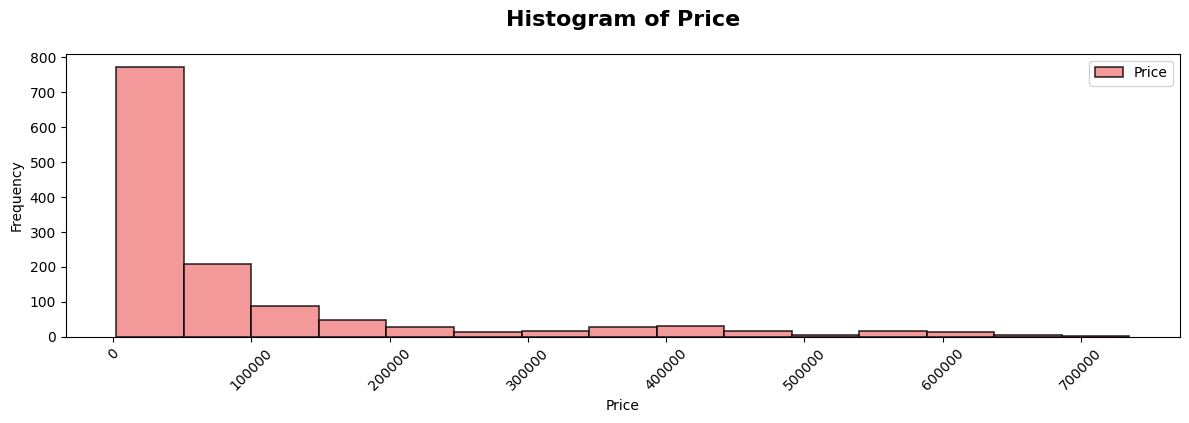

min 2250.0
max 735000.0


In [ ]:
import matplotlib.pyplot as plt
#histogram for price:
plt.figure(figsize=(12, 4))
plt.hist(data['Price'], bins=15, alpha=0.8,edgecolor='black',linewidth=1.2,color='lightcoral')
plt.title(f"Histogram of {'Price'}",fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Price')
plt.ylabel("Frequency")
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend(['Price'], loc='upper right')

plt.show()
print('min',data['Price'].min())
print('max',data['Price'].max())

**Observations from the Histogram:**
1.   A long tail extends towards the right of the histogram indicating the data is right/positively skewed.
2.  The highest bar on the left suggests that a large number of products fall into the lower price range.
1.   As the price increases, the frequency of products in each price range decreases significantly.

**Insights about the market/smartphones:**

*   The market may consist primarily of low-priced products, with only a few
expensive ones.
*   Affordability is a dominant factor, but there is a small segment for premium-priced products.






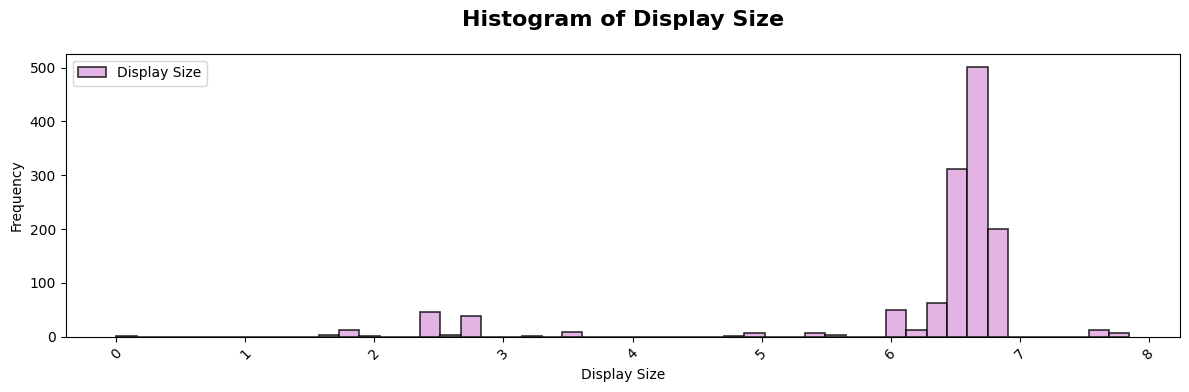

min 0.0
max 7.85


In [ ]:
#histogram for Display Size:
plt.figure(figsize=(12, 4))
plt.hist(data['Display Size'], bins=50, alpha=0.8,edgecolor='black',linewidth=1.2,color='plum')
plt.title(f"Histogram of {'Display Size'}",fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Display Size')
plt.ylabel("Frequency")
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend(['Display Size'], loc='upper left')

plt.show()
print('min',data['Display Size'].min())
print('max',data['Display Size'].max())

**Observations from the Histogram:**
1.   A long tail extends towards the left of the histogram indicating the data is left/negatively skewed.
2.  Most products have larger display sizes, as evidenced by the concentration of bars toward the right.
1.   Products with smaller display sizes (the tail on the left) are much less common.

**Insights about the market/smartphones:**

*   A trend favoring larger screens, which is consistent with market demand for products with bigger displays.

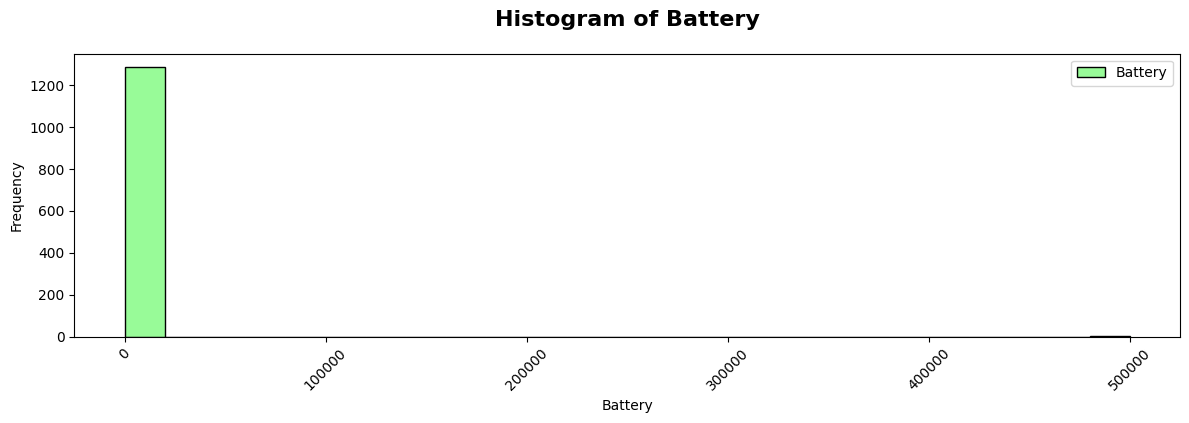

min 30.0
max 500018.0


In [ ]:
#histogram for Battery:
plt.figure(figsize=(12, 4))
plt.hist(data['Battery'], bins=25,edgecolor='black',color='palegreen')
plt.title(f"Histogram of {'Battery'}",fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Battery')
plt.ylabel("Frequency")
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend(['Battery'], loc='upper right')

plt.show()
print('min',data['Battery'].min())
print('max',data['Battery'].max())

**Observations from the Histogram:**
1.   Due to very little variation in the column, almost all the values are concentrated near 0.0 after normalization.
2.  A lack of diversity in the battery capacities is evident.

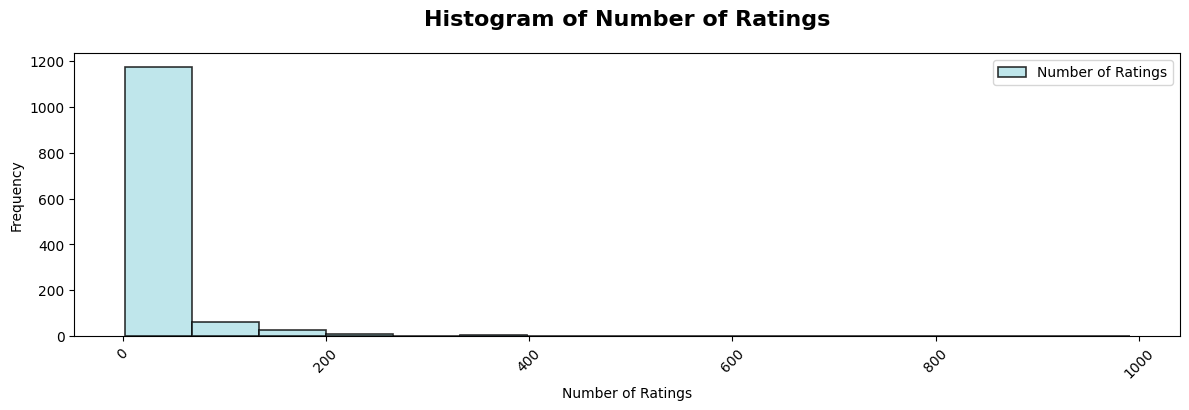

min 2.0
max 991.0


In [ ]:
#histogram for Number of Ratings:
plt.figure(figsize=(12, 4))
plt.hist(data['Number of Ratings'], bins=15, alpha=0.8,edgecolor='black',linewidth=1.2,color='powderblue')
plt.title(f"Histogram of {'Number of Ratings'}",fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Ratings')
plt.ylabel("Frequency")
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend(['Number of Ratings'], loc='upper right')

plt.show()
print('min',data['Number of Ratings'].min())
print('max',data['Number of Ratings'].max())

**Observations from the Histogram:**
1.   A long tail extends towards the right of the histogram indicating the data is right/positively skewed.
2.  Most of the products have a very low number of ratings

**Insights about the market/smartphones:**

*   This suggests that the majority of the products are either new, less popular, or have not been widely rated by customers.
*   Only a handful of products received a high number of ratings.



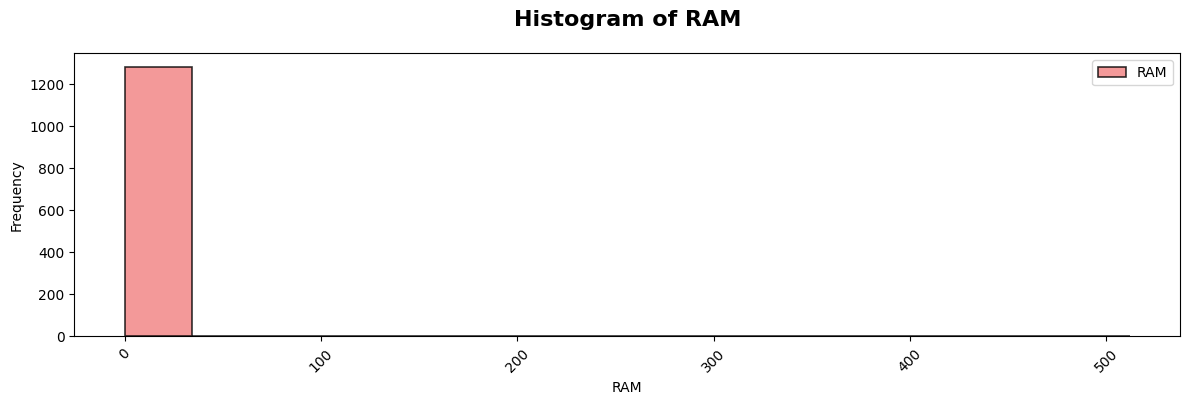

min 0.004
max 512.0


In [ ]:
#histogram for RAM:
plt.figure(figsize=(12, 4))
plt.hist(data['RAM'], bins=15, alpha=0.8,edgecolor='black',linewidth=1.2,color='lightcoral')
plt.title(f"Histogram of {'RAM'}",fontsize=16, fontweight='bold', pad=20)
plt.xlabel('RAM')
plt.ylabel("Frequency")
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend(['RAM'], loc='upper right')

plt.show()
print('min',data['RAM'].min())
print('max',data['RAM'].max())

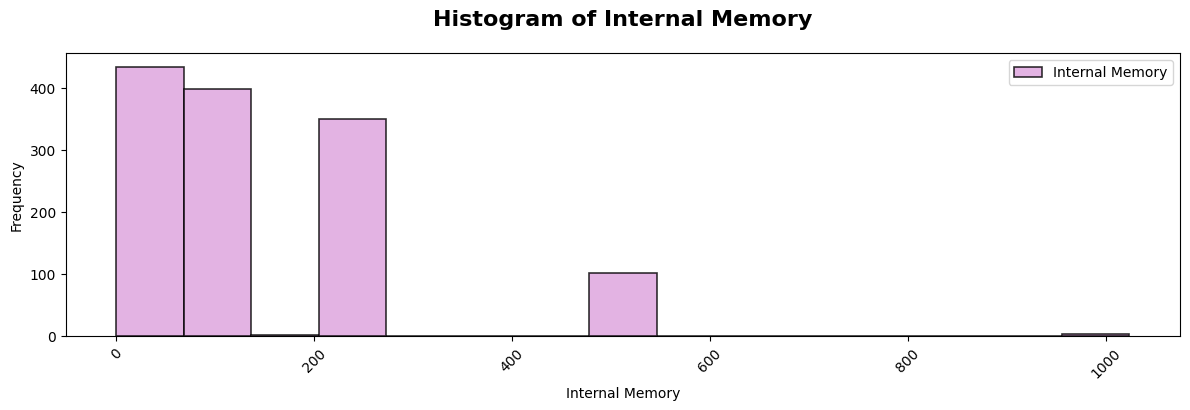

min 0.004
max 1024.0


In [ ]:
#histogram for Internal Memory:
plt.figure(figsize=(12, 4))
plt.hist(data['Internal Memory'], bins=15, alpha=0.8,edgecolor='black',linewidth=1.2,color='plum')
plt.title(f"Histogram of {'Internal Memory'}",fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Internal Memory')
plt.ylabel("Frequency")
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend(['Internal Memory'], loc='upper right')

plt.show()
print('min',data['Internal Memory'].min())
print('max',data['Internal Memory'].max())

**Observations from the Histogram:**
1.   The histogram shows a left-skewed distribution, where most of the frequency is concentrated near the lower range of the normalized internal memory values.
2.  As the internal memory size increases (toward 1.0), the frequency drops significantly.
1.   Higher internal memory capacities are significantly less common, as seen in the smaller bars toward the right.
4.  Internal memory is typically a discrete variable (e.g., 64GB, 128GB, 256GB, etc.), and the histogram reflects this, with clear gap

#### **Bar Charts**

Using bar charts to visualize the categorical columns

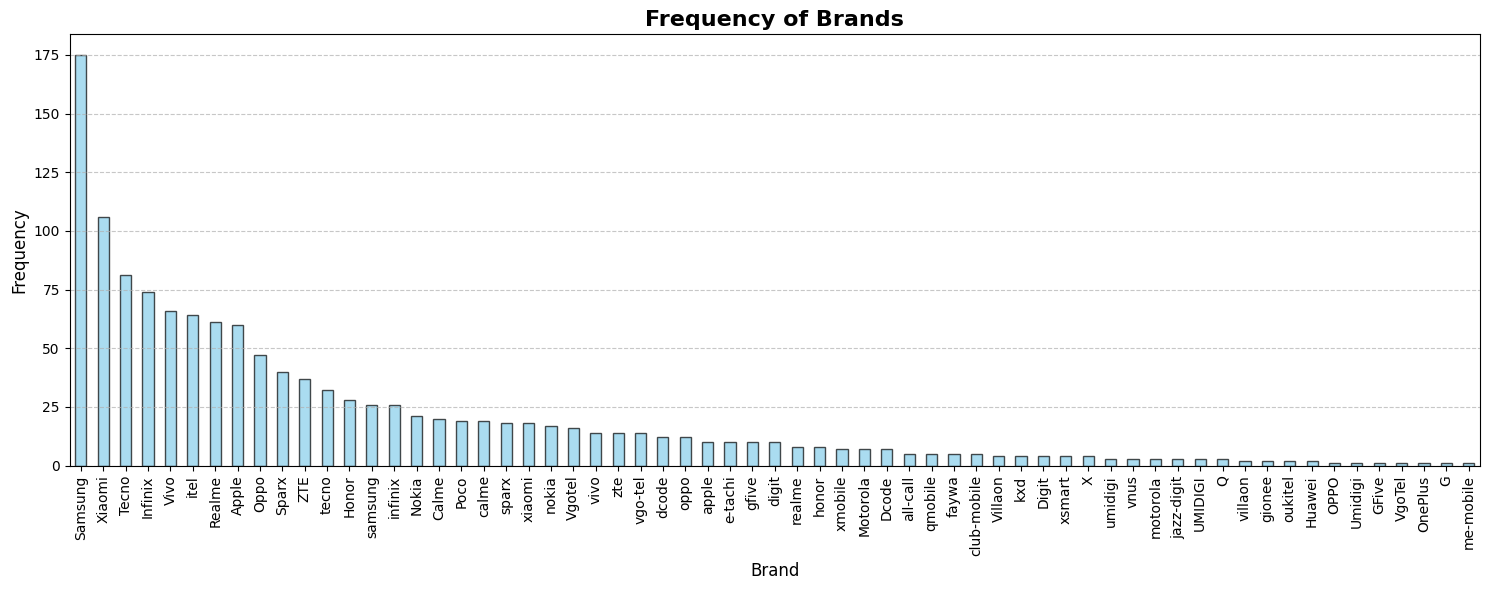

In [ ]:
# Bar Chart for Brand
plt.figure(figsize=(15, 6))
data['Brand'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Frequency of Brands', fontsize=16, fontweight='bold')
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

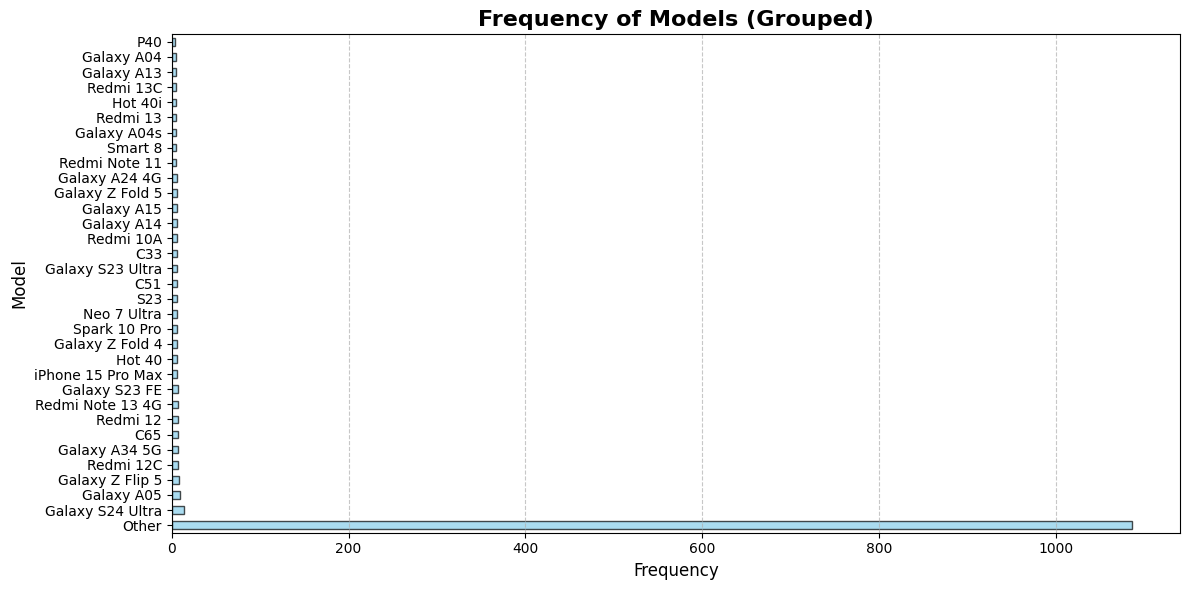

In [ ]:
# Bar Chart for Model
model_counts = data_copy['Model'].value_counts()
threshold = 6
data['Model_Grouped'] = data['Model'].apply(
    lambda x: x if model_counts[x] >= threshold else 'Other'
)

# Plot horizontal bar chart for grouped data
plt.figure(figsize=(12, 6))
data['Model_Grouped'].value_counts().plot(kind='barh', color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Frequency of Models (Grouped)', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


 The Model column contains many unique values, and grouping less frequent ones improves readability and interpretation. This code groups less frequent models into a category called 'Other' (based on a threshold) and visualizes the frequency of each mode.

#### **Box Plots**

Using box plots to visualize the presence of outliers and guage the spread of data.

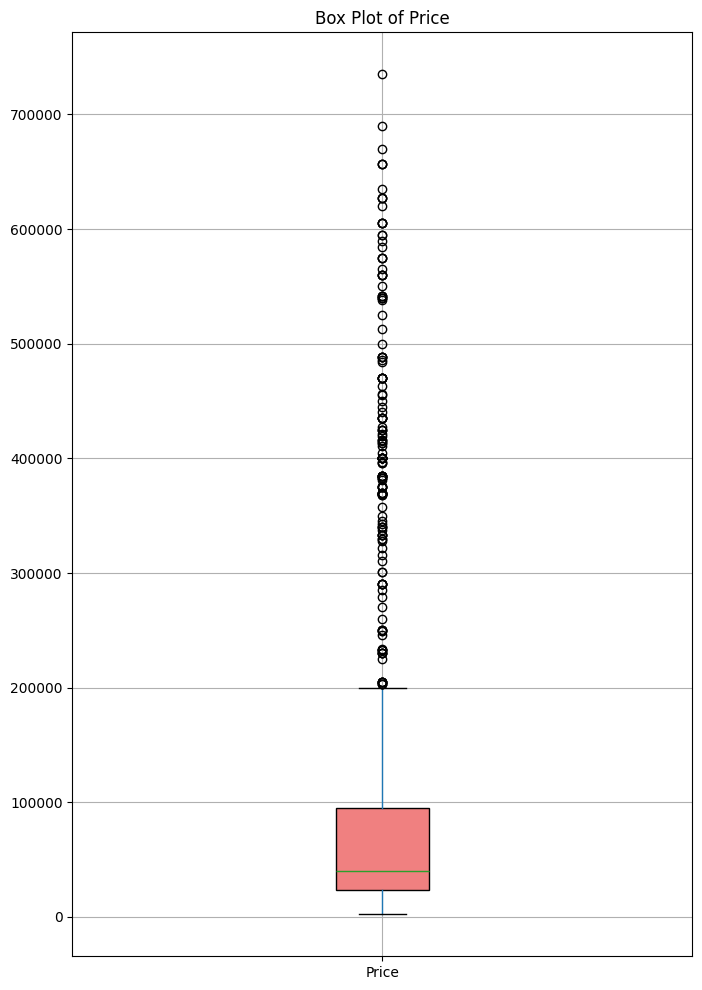

In [ ]:
#box plot for Price
plt.figure(figsize=(8, 12))
data.boxplot(column=['Price'], patch_artist=True, boxprops=dict(facecolor='lightcoral'))
plt.title('Box Plot of Price')
plt.show()

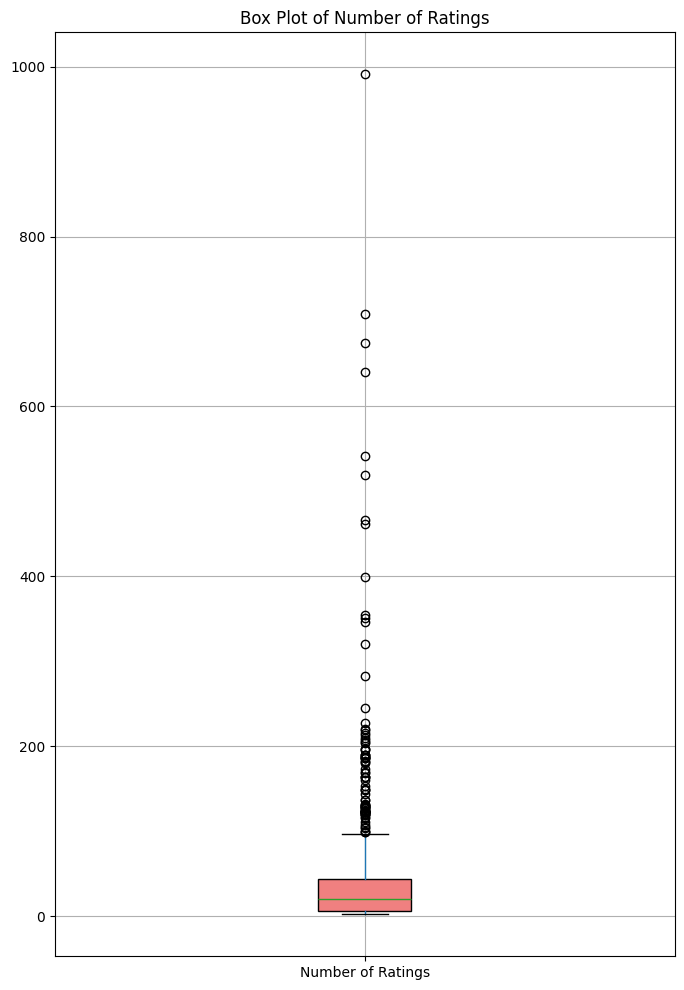

In [ ]:
#box plot for Number of Ratings
plt.figure(figsize=(8, 12))
data.boxplot(column=['Number of Ratings'], patch_artist=True, boxprops=dict(facecolor='lightcoral'))
plt.title('Box Plot of Number of Ratings')
plt.show()

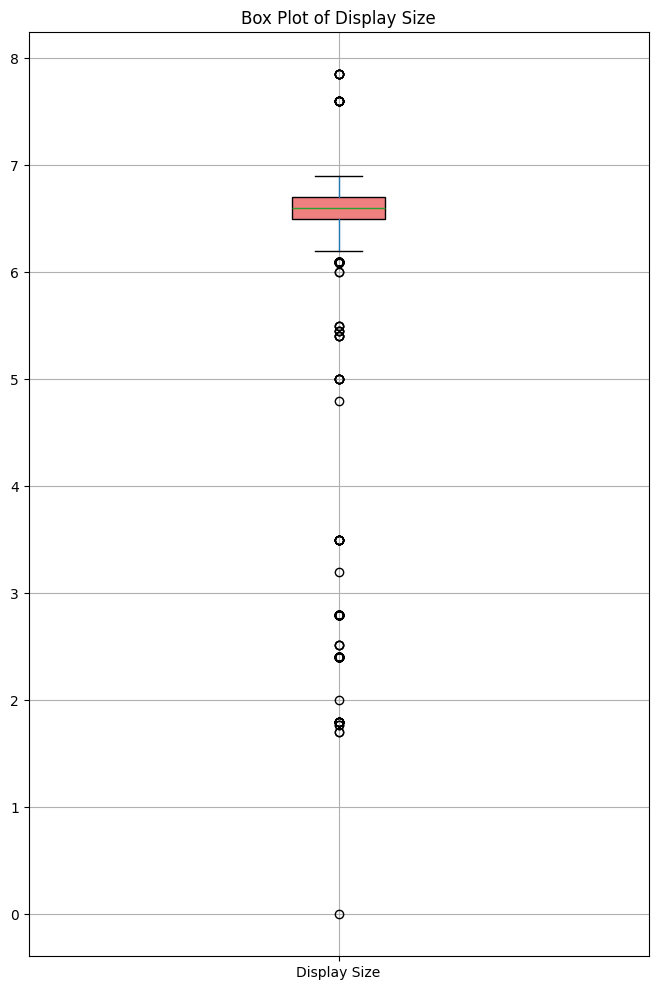

In [ ]:
#box plot for Number of Display Size
plt.figure(figsize=(8, 12))
data.boxplot(column=['Display Size'], patch_artist=True, boxprops=dict(facecolor='lightcoral'))
plt.title('Box Plot of Display Size')
plt.show()

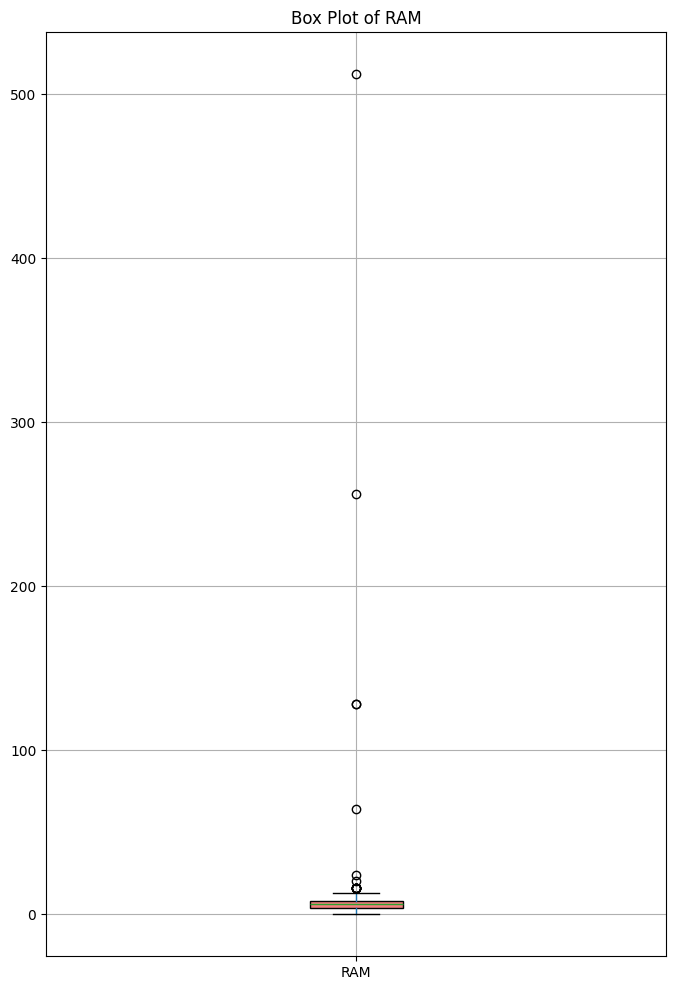

In [ ]:
#box plot for Number of RAM
plt.figure(figsize=(8, 12))
data.boxplot(column=['RAM'], patch_artist=True, boxprops=dict(facecolor='lightcoral'))
plt.title('Box Plot of RAM')
plt.show()

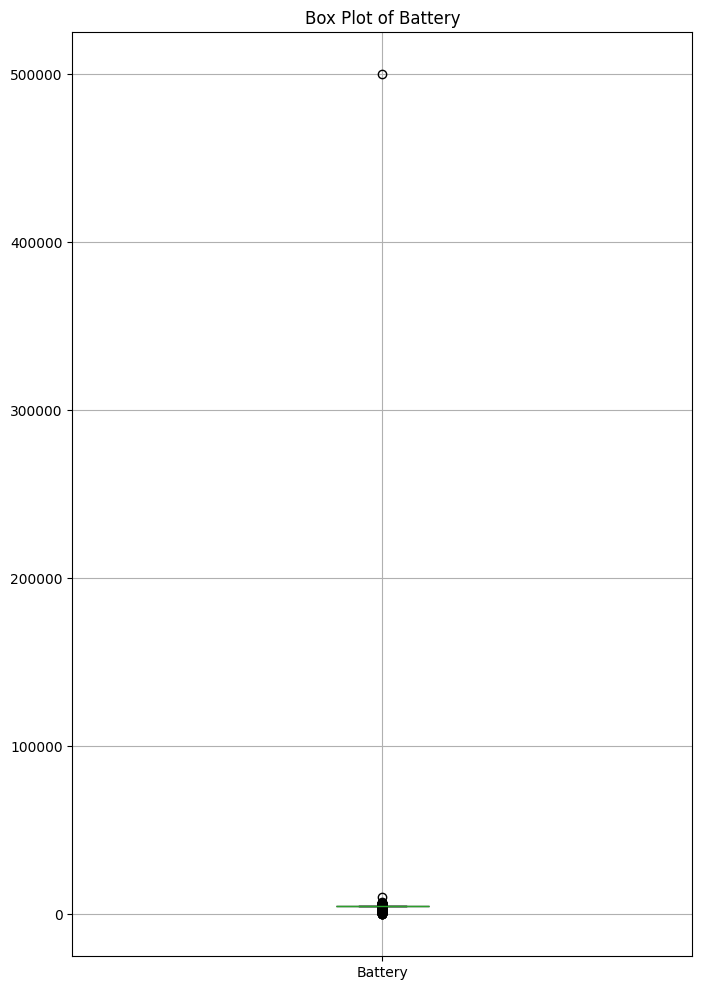

In [ ]:
#box plot for Number of Battery
plt.figure(figsize=(8, 12))
data.boxplot(column=['Battery'], patch_artist=True, boxprops=dict(facecolor='lightcoral'))
plt.title('Box Plot of Battery')
plt.show()

The Box is very small due to almost similar values

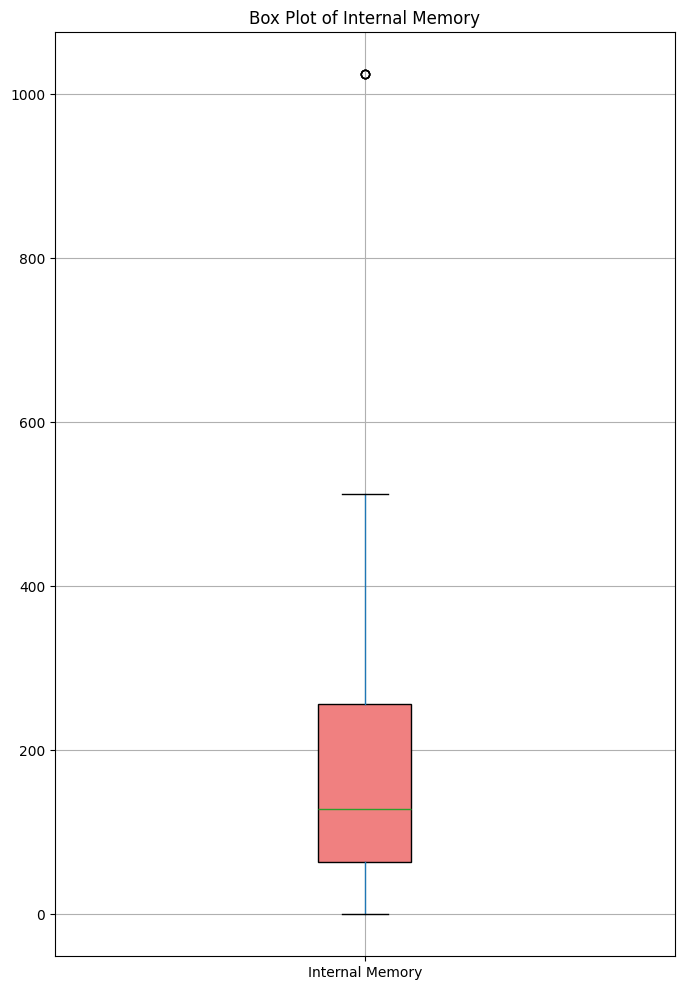

In [ ]:
#box plot for Number of Internal Memory
plt.figure(figsize=(8, 12))
data.boxplot(column=['Internal Memory'], patch_artist=True, boxprops=dict(facecolor='lightcoral'))
plt.title('Box Plot of Internal Memory')
plt.show()

### **Bivariate and Multivariate Analysis**


##### **Scatter Plots**

**1. Scatter plot for price vs RAM to check if higher RAM leads to higher price**

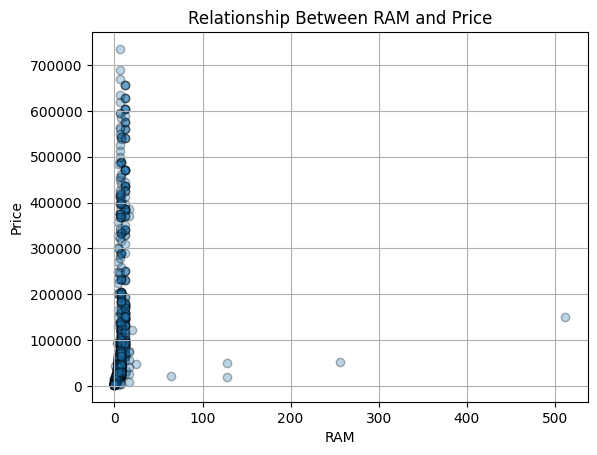

In [ ]:
plt.scatter(data['RAM'], data['Price'], alpha=0.3, edgecolors='k')

plt.title('Relationship Between RAM and Price')
plt.xlabel('RAM')
plt.ylabel('Price')
plt.grid(True)

plt.show()

**Observations from the Scatter Plot:**
1.  Most data points are clustered around lower RAM values (below 20-30 GB).
2.  This indicates that the majority of devices have smaller RAM sizes, and there is little variation in the price for these smaller RAM sizes.
3.  A few data points with significantly higher RAM values (above 100 GB) are present, but they do not follow a consistent trend in terms of price.
4.  There does not seem to be a clear linear relationship between RAM size and price.
5.  There are some very high-priced devices regardless of their RAM.

**Insights about the market/smartphones:**

*   The lack of a strong trend suggests that RAM might not be the sole or dominant factor determining price.
*   Additional variables may need to be analyzed for a more comprehensive understanding of price determinants.


**2. Scatter plot for Battery vs Display Size to check if larger screens require bigger batteries**

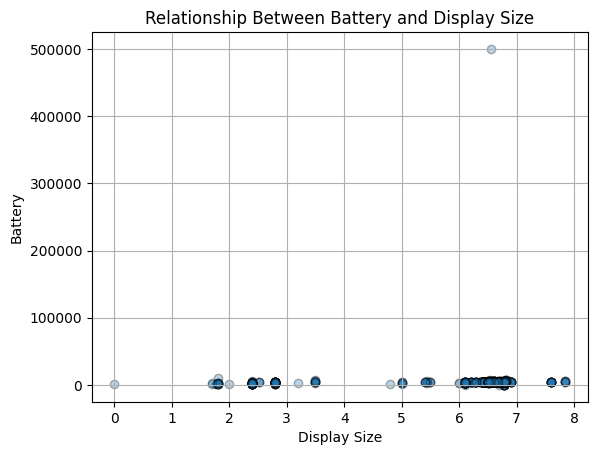

In [ ]:
plt.scatter(data['Display Size'], data['Battery'], alpha=0.3, edgecolors='k')

plt.title('Relationship Between Battery and Display Size')
plt.xlabel('Display Size')
plt.ylabel('Battery')
plt.grid(True)

plt.show()

**Observations from the Scatter Plot:**
1.  Most data points are concentrated in the range of display sizes between 5 and 7 inches.
2.  The battery values for these display sizes do not show a clear upward trend, indicating that larger screens do not necessarily have significantly larger batteries.
3.  The plot does not exhibit a strong or consistent relationship between display size and battery capacity.
4.  For smaller display sizes (less than 5 inches), there are fewer data points.

**Insights about the market/smartphones:**

*   The lack of a strong trend suggests that display size alone may not be the primary factor determining battery capacity.


**3. Scatter plot for Number of Ratings vs Price to check if higher-priced products are more popular**

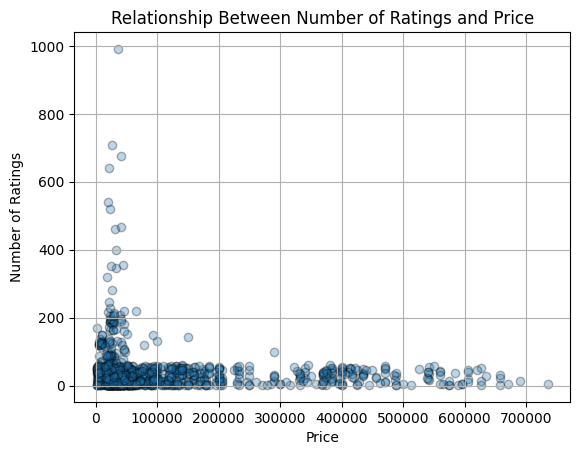

In [ ]:
plt.scatter(data['Price'], data['Number of Ratings'], alpha=0.3, edgecolors='k')

plt.title('Relationship Between Number of Ratings and Price')
plt.xlabel('Price')
plt.ylabel('Number of Ratings')
plt.grid(True)

plt.show()

**Observations from the Scatter Plot:**
1.  Most data points with a high number of ratings are concentrated at lower price ranges (below 100,000). This suggests that more affordable products tend to be more popular or accessible, receiving more ratings.
2.  High-priced products (above 300,000) have fewer ratings, which could indicate limited affordability or a niche market for these products.
3.  A few outliers exist with exceptionally high ratings, but these are almost exclusively in the lower price range.

**Insights about the market/smartphones:**

*   Lower-priced products tend to attract a higher number of ratings, suggesting they are more popular or widely purchased.
*   Higher-priced products, while likely targeting a more specialized audience, tend to receive fewer ratings, reflecting their limited reach.

**4. Scatter plot for Internal Memory vs Price to check if more storage significantly increases product cost**

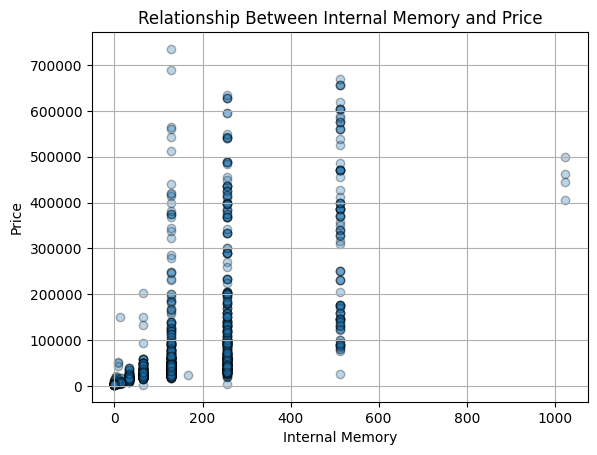

In [ ]:
plt.scatter(data['Internal Memory'], data['Price'], alpha=0.3, edgecolors='k')

plt.title('Relationship Between Internal Memory and Price')
plt.xlabel('Internal Memory')
plt.ylabel('Price')
plt.grid(True)

plt.show()

**Observations from the Scatter Plot:**
1.  The data points are grouped into distinct clusters corresponding to common internal memory sizes, such as 64GB, 128GB, 256GB, 512GB, and 1TB. This reflects standard memory configurations for most products.
2.  Within each cluster, there is an upward trend in price as the internal memory size increases. This suggests that more storage tends to increase the cost.

**Insights about the market/smartphones:**

*   The relationship appears somewhat non-linear, with diminishing returns in price for very high memory sizes.

### **Correlation Matrix**

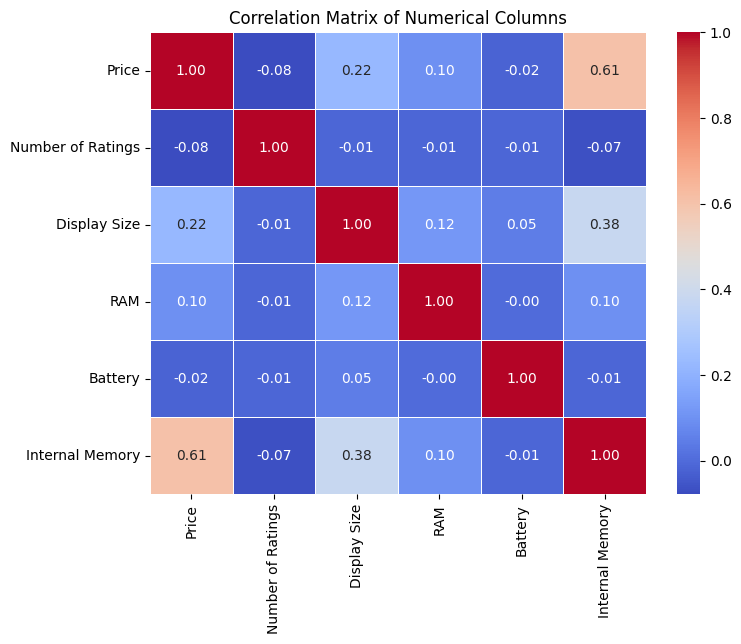

In [ ]:
import seaborn as sns
numerical_columns = ['Price', 'Number of Ratings', 'Display Size', 'RAM', 'Battery', 'Internal Memory']
correlation_matrix = data[numerical_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

**Strongest Correlation:**\
There is a strong positive correlation between internal memory and price. This suggests that products with more storage tend to have higher prices, aligning with the earlier scatter plot observations.\
**Moderate Correlation:**\
There is a weak to moderate positive correlation between display size and price. Larger screens may slightly contribute to higher prices but are not a dominant factor.\
**Weak Correlation:**\
The correlation between RAM and price is very weak, indicating that RAM alone does not strongly determine the price.\
There is a moderate correlation between display size and internal memory, suggesting that devices with larger screens might also tend to have more internal memory.\
**Negligible or Negative Correlation:**\
A weak negative correlation suggests that lower-priced products are more likely to receive higher numbers of ratings, which aligns with affordability and accessibility for a wider audience.\
Virtually no correlation between battery size and price, indicating battery capacity does not significantly influence product cost.\
A slight negative correlation indicates that products with higher internal memory are not necessarily the most frequently rated.

### **Pair Plots**
1. Pair plots for determining relationships among price and other numerical columns

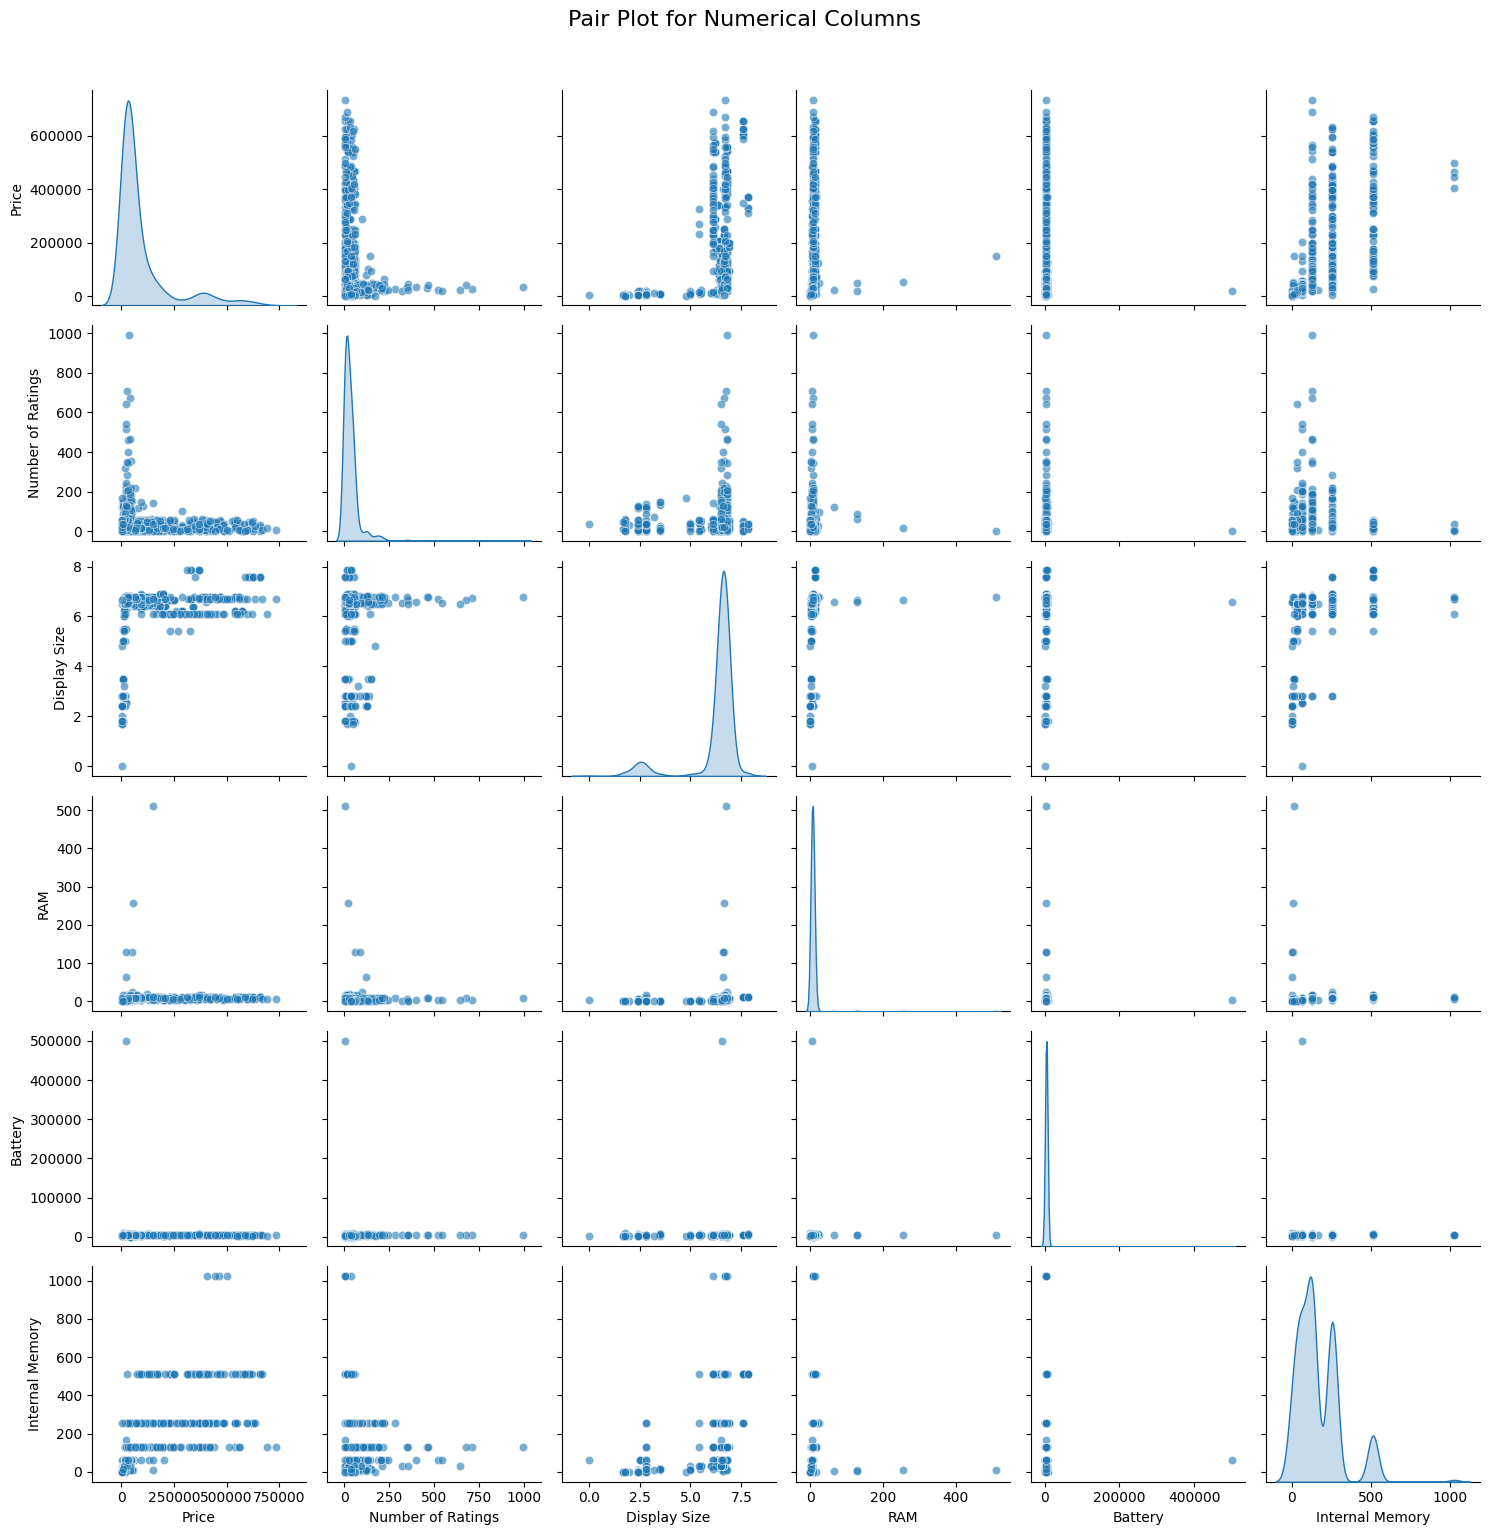

In [ ]:
numerical_columns = ['Price', 'Number of Ratings', 'Display Size', 'RAM', 'Battery', 'Internal Memory']
sns.pairplot(
    data[numerical_columns],
    diag_kind='kde',
    plot_kws={'alpha': 0.6},
    height=2.5
)

plt.suptitle("Pair Plot for Numerical Columns", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

### **Feature Analysis**

Using correlation analysis to measure how strongly each numerical feature correlates with the target.

Correlation of display size with the target variable (Price):
                 Price  Display Size
Price         1.000000      0.220874
Display Size  0.220874      1.000000


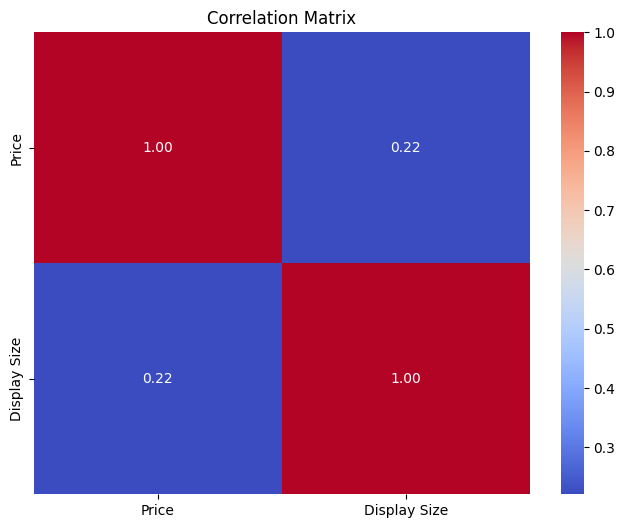

In [ ]:
correlation_matrix = data[['Price', 'Display Size']].corr()

print("Correlation of display size with the target variable (Price):")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Correlation of RAM with the target variable (Price):
          Price       RAM
Price  1.000000  0.095775
RAM    0.095775  1.000000


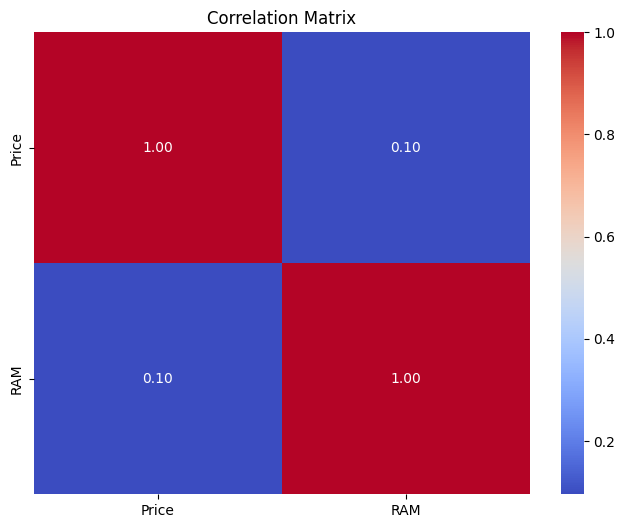

In [ ]:
correlation_matrix = data[['Price', 'RAM']].corr()

print("Correlation of RAM with the target variable (Price):")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Correlation of Battery with the target variable (Price):
            Price   Battery
Price    1.000000 -0.021505
Battery -0.021505  1.000000


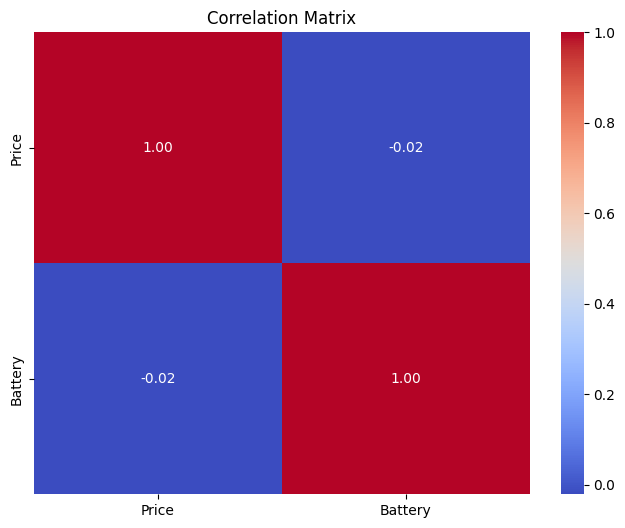

In [ ]:
correlation_matrix = data[['Price', 'Battery']].corr()

print("Correlation of Battery with the target variable (Price):")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Correlation of Internal Memory with the target variable (Price):
                    Price  Internal Memory
Price            1.000000         0.608172
Internal Memory  0.608172         1.000000


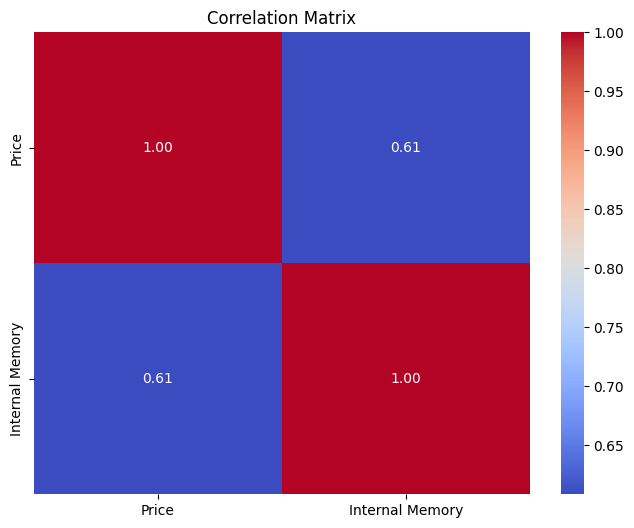

In [ ]:
correlation_matrix = data[['Price', 'Internal Memory']].corr()

print("Correlation of Internal Memory with the target variable (Price):")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Correlation of Number of Ratings with the target variable (Price):
                      Price  Number of Ratings
Price              1.000000          -0.078439
Number of Ratings -0.078439           1.000000


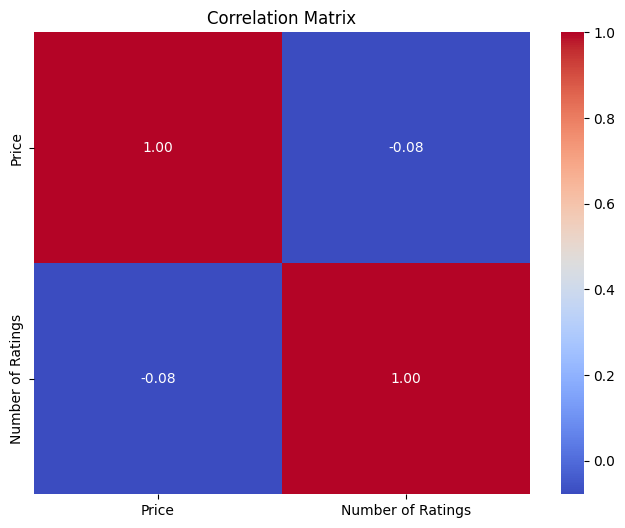

In [ ]:
correlation_matrix = data[['Price', 'Number of Ratings']].corr()

print("Correlation of Number of Ratings with the target variable (Price):")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

**Observation**
Among the features analyzed, Internal Memory shows the strongest correlation with the target variable (Price). It should be prioritized for predictive modeling.

Using group-by summaries to measure how strongly each categorical feature correlates with the target.

Aggregated Statistics by Brand:
      Brand           mean    median
0     Apple  403804.921595  413000.0
1     Calme    8690.000000    9500.0
2     Dcode   34285.714286   37500.0
3     Digit   21500.000000   22500.0
4         G    9000.000000    9000.0
..      ...            ...       ...
58     vnus   12399.000000   11099.0
59   xiaomi   75371.222222   36549.0
60  xmobile    3641.285714    3799.0
61   xsmart   20249.000000   20449.0
62      zte   26299.071429   21249.0

[63 rows x 3 columns]


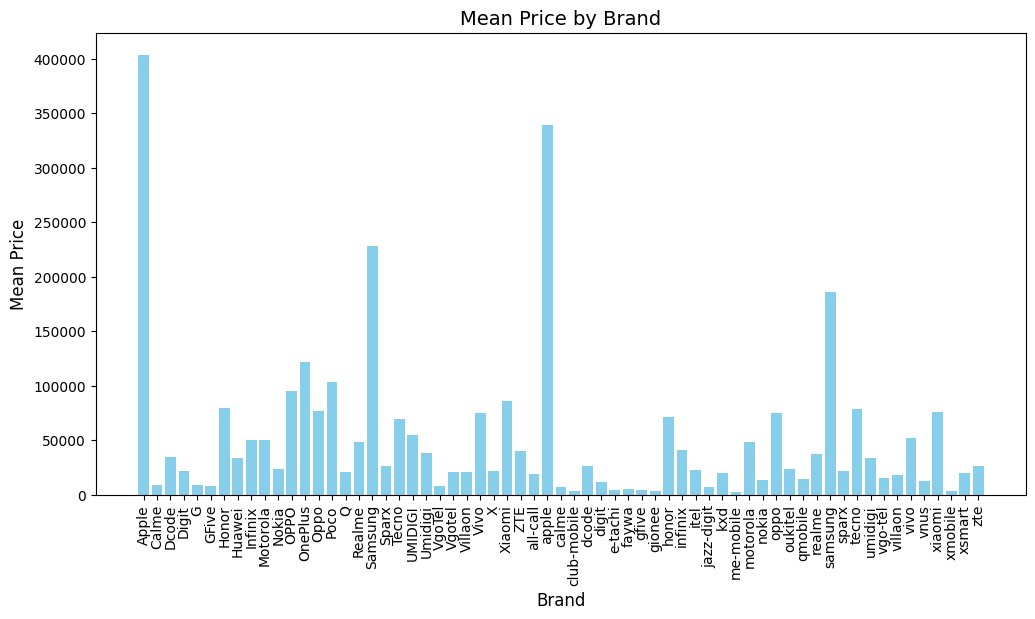

Aggregated Statistics by Model:
                  Model           mean         median
0                    12  180000.000000  180000.000000
1                 12 4G   60000.000000   60000.000000
2                12+ 5G   75000.000000   75000.000000
3                   12T   94698.823928   94698.823928
4               12T Pro   94698.823928   94698.823928
..                  ...            ...            ...
684  nubia Focus Pro 5G   54700.000000   54700.000000
685         nubia Music   25000.000000   25000.000000
686         nubia Neo 2   55000.000000   55000.000000
687    nubia V60 Design   31000.000000   31000.000000
688        smart Nova 5   18000.000000   18000.000000

[689 rows x 3 columns]


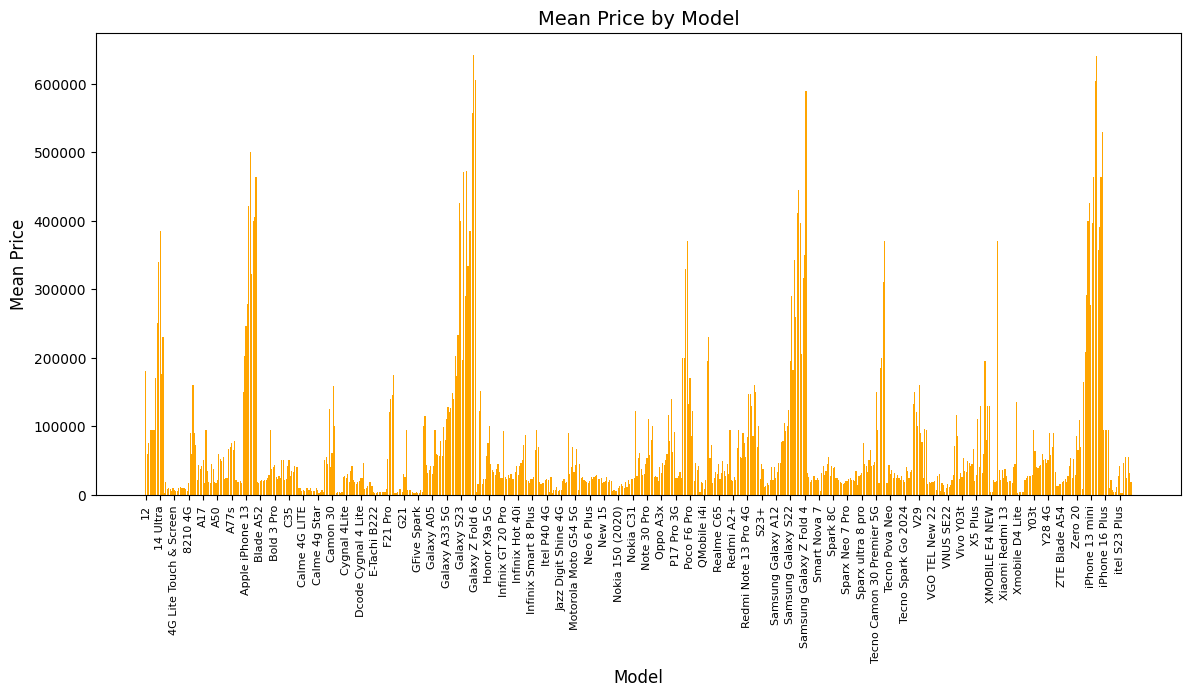

In [ ]:
brand_group = data.groupby('Brand')['Price'].agg(['mean', 'median']).reset_index()

print("Aggregated Statistics by Brand:")
print(brand_group)

plt.figure(figsize=(12, 6))
plt.bar(brand_group['Brand'], brand_group['mean'], color='skyblue')
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Mean Price', fontsize=12)
plt.title('Mean Price by Brand', fontsize=14)
plt.xticks(rotation=90)
plt.show()

model_group = data.groupby('Model')['Price'].agg(['mean', 'median']).reset_index()

print("Aggregated Statistics by Model:")
print(model_group)

plt.figure(figsize=(14, 6))
plt.bar(model_group['Model'], model_group['mean'], color='orange')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Mean Price', fontsize=12)
plt.title('Mean Price by Model', fontsize=14)
plt.xticks(ticks=range(0, len(model_group), 10), labels=model_group['Model'][::10], rotation=90, fontsize=8)
plt.show()


# **Deliverable III**

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report


### Feature Selection

**Selected Features:**
* Internal memory: strong positive correlation wiith price because devices with larger internal memory typically have higher prices due to better storage capacity.
* Scatter plots reveal some upward trend between Display Size and Price.
* RAM could interact with other features (like Internal Memory) in influencing price, so it’s worth exploring its contribution further.
* Some brands may generally produce higher-priced devices than others (e.g., premium brands like Apple or Samsung).
* Model is categorical and represents the specific device type, which can heavily influence Price.

**Excluded Features:**
* Battery has very weak correlation with Price, Histogram and scatter plots show almost no variance in battery values after normalization, which suggests it carries minimal information.
* The number of ratings reflects a product’s popularity rather than its price. For example, a cheap device may have many ratings, but that doesn’t mean it’s expensive.

In [70]:
#since the model column is one hot encoded, we have individual columns for each category so we are gathering all the columns that are encoded into a single variable
model_columns = [col for col in data.columns if col.startswith('Model_')]
selected_features = ['RAM_Scaled',  'Display_Size_Scaled', 'Internal_Memory_Scaled','Brand_Encoded']
selected_features.extend(model_columns)


X = data[selected_features]
y = data['Price_Scaled'] #storing target variable into y 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (1029, 692)
Testing data shape: (258, 692)


**Observation:**

* Relevant features (RAM_Scaled, Internal_Memory_Scaled, etc.) and the target column (Price_Scaled) are selected.

* The data is split into training (80%) and testing (20%) sets.

**Insight:**


*   Selecting the right features ensures the model focuses on relevant predictors.

*   Splitting the dataset prevents overfitting and helps evaluate model performance on unseen data.




### Model Selection

**Machine Learning Model:**
* Starting with a simple baseline model i.e Random Forest Regression Model because it handles non-linear relationships effectively and is robust to outliers.

**Deep Learning Model:**
* Fully connected Neural Network
* Useful for capturing complex non-linear relationships

### Model Training

In [71]:
#Machine Learning Model
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf}, MSE: {mse_rf}, R2: {r2_rf}")

Random Forest - MAE: 0.03021093738497796, MSE: 0.003022301695357455, R2: 0.9027580822949589


**Observation:**

* A RandomForestRegressor is trained on the selected features.
* Predictions are made on the test set, and performance is evaluated using MSE and R2.

**Insight:**

* A lower MSE indicates better prediction accuracy.

In [72]:
#Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

y_pred_nn = model.predict(X_test)

mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network - MSE: {mse_nn}, R2: {r2_nn}")

C:\Users\welcome\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1779 - mae: 0.2891 - val_loss: 0.0261 - val_mae: 0.0821
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0293 - mae: 0.1018 - val_loss: 0.0186 - val_mae: 0.0921
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0184 - mae: 0.0823 - val_loss: 0.0143 - val_mae: 0.0766
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0140 - mae: 0.0719 - val_loss: 0.0124 - val_mae: 0.0787
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - mae: 0.0611 - val_loss: 0.0098 - val_mae: 0.0671
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - mae: 0.0492 - val_loss: 0.0077 - val_mae: 0.0526
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - mae: 0.0417 - val_loss: 0.0084 - val_mae: 0.0676
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0347 - val_loss: 0.0066 - val_mae: 0.0542
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - mae

### Comparison of Results

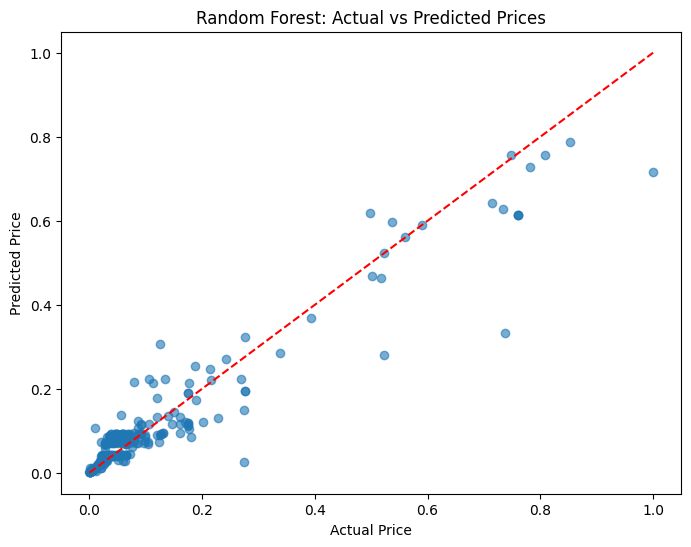

In [73]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title('Random Forest: Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()


### Observations
* Many data points are clustered near the lower price range (bottom left corner). This suggests that the dataset has more examples with lower prices.
* As the price increases, the predictions tend to deviate more from the diagonal line. This may indicate that the model struggles to predict higher-priced examples accurately which may be due to Insufficient training examples for higher-priced items or Model limitations in capturing relationships for extreme values.

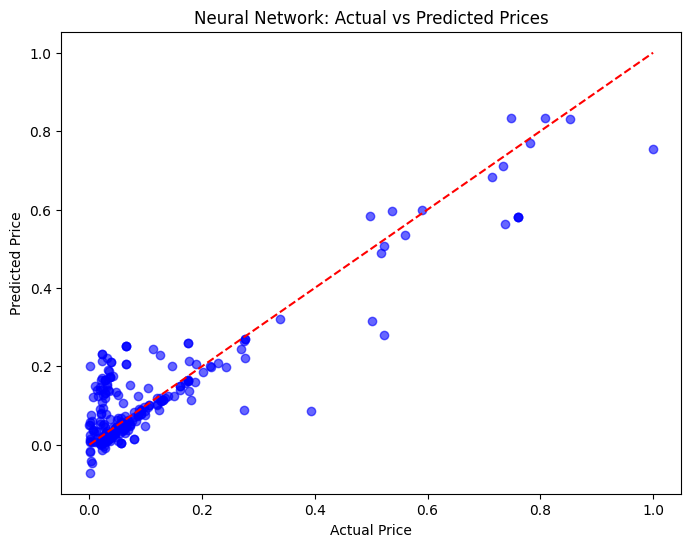

In [74]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title('Neural Network: Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

### Observation:

* The plot shows that the Neural Network captures the trend reasonably well for many data points, but there are deviations, especially for extreme values.